# Part 1 - Data

![What data scientist spent most doing](./imlp1_images/pie.jpg)

[Gil Press - Forbes, Cleaning Big Data: Most Time-Consuming, Least Enjoyable Data Science Task, Survey Says](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#164fea706f63)

## What is Machine Learning

Machine learning is automated process that extracts patterns from data. To illustrate basic concepts of machine learning we will use supervised machine learning that automatically learns and builds model of relationships between a set of *descriptive features* and a *target feature* (*labels*) based on a set of historical examples or *instances*. We can then use this model to make predictions for new instances unseen in learning period.

Following schema illustrates common process of machine learning.

![What is machine learning](./imlp1_images/machine_learning_1.png)

## Steps in "Almost Every" Data Problem

1. [Define the Problem](#define)
2. [Load and Get to Know Your Data](#load)
3. [Correct, Complete, Create, and Convert](#correct)
4. [Exploratory Data Analysis](#eda)
5. [Prepare Data](#prepare)
5. [Model](#model)

<a id="define"></a>
## Define the Problem

We are gonna predict **whether it rains tomorrow** from today's data in locations all over Australia.

It is a *binary classification problem*, we want also some insights into what features and their values signal rain tomorrow (if any). We got data from [Australian Weather Bureau](http://www.bom.gov.au/) for education purposes and downloaded the dataset from [Kaggle Weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package).

![](./imlp1_images/abm.png)

## Python

We will use following libraries in this lecture

[![pandas](./imlp1_images/pandas.png)](https://pandas.pydata.org)
[![scikit-learn](imlp1_images/scikit1.png)](https://scikit-learn.org/stable/)
[![numpy](imlp1_images/numpy.png)](https://numpy.org)

In [1]:
# import some basic libraries to do analysis and ML
import pandas as pd
import numpy as np
import sklearn as sk
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Visualization details
mpl.style.use('ggplot')
sns.set_style('white')
mpl.rcParams['figure.figsize'] = 15,7


import plotly.io as pio
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import machine_learning_python as mlp

import os
notebook_output_format = os.environ['NOTEBOOK_OUTPUT_FORMAT'] if 'NOTEBOOK_OUTPUT_FORMAT' in os.environ else 'jupyter-lab'
if notebook_output_format == 'jupyter-book':
    png_renderer = pio.renderers['png']
    png_renderer.width = 500
    pio.renderers.default = 'png'
else:    
    png_renderer = pio.renderers['png']
    png_renderer.height = 400
    pio.renderers.default = 'png'

<a id="load"></a>
## Load and Get to Know Your Data

We load data and have the first look on what is available to us, what features we have, their types, missing values, what might be wrong, what we can fix on our side, what has to be fixed with data provider etc.

It is worth to validate the basic assumptions about the data:

* Do we have anough samples?
* Are basic axioms valid eg. uniqueness of ids, having one measurement per day, ...
* What labels do we have? Is it binary?

Some features that are available to us:

1. *RainTomorrow* is our binary target (dependent) features we will be predicting or explaining using descriptive (independent) features.
1. *Date*, *Location* are nominal (categorical) features spanning Australia and about 9 years of measurements. We will need to convert it to numerical features. Some locations are close together, some are very distant, we could probably use location to give information about adjacent rain and combine it with wind direction.
1. *WindDir*s are nominal features about wind direction. We will have to convert  it to numerical features.
1. *RainToday* is nominal info about raining today. We will have to convert  it to numerical features. It will be probably the feature with the most signal as it is likely that when it rains today, it will rain tomorrow.
1. *RISK_MM* feature stands out, it looks like some technical measure, we will have to check later.
1. There is a group of numerical features describing morning and afternoon measurements. We have to check distributions and fill in missing values.

In [2]:
# Read data from local .csv file
df = pd.read_csv('../../data/weatherAUS.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [3]:
df.sample(5)[df.columns[:10]]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am
23000,2015-10-09,NorfolkIsland,15.3,19.2,0.0,6.8,4.4,SE,52.0,SE
86594,2013-12-04,Cairns,22.2,30.5,0.0,9.0,11.9,E,37.0,S
67001,2012-03-20,Melbourne,15.8,27.6,0.0,6.8,11.1,N,69.0,N
32135,2015-07-28,Sydney,6.4,17.3,0.0,NaN,9.6,NaN,NaN,WNW
38806,2017-06-17,WaggaWagga,6.6,16.1,0.0,NaN,NaN,ESE,19.0,ENE


In [4]:
df.sample(5)[df.columns[10:20]]

,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am
68741,NNW,2.0,6.0,87.0,60.0,1028.9,1027.2,7.0,8.0,10.5
13721,S,13.0,17.0,53.0,20.0,1029.4,1025.3,NaN,NaN,17.9
92183,N,17.0,15.0,61.0,51.0,1017.0,1012.4,3.0,1.0,25.8
5754,ENE,4.0,17.0,87.0,53.0,1019.6,1017.1,NaN,NaN,19.0
80844,SSE,11.0,11.0,100.0,48.0,1017.7,1013.9,NaN,NaN,14.9


In [5]:
df.sample(5)[df.columns[20:]]

,Temp3pm,RainToday,RISK_MM,RainTomorrow
141104,25.0,No,0.0,No
133495,29.3,No,0.0,No
9197,20.8,No,0.0,No
100173,12.8,No,0.0,No
3454,26.3,Yes,0.0,No


In [13]:
d = df.groupby('Location').agg(Count=('Date', 'count')).sort_values('Count', ascending=False)
print(f'We have {df.Location.nunique()} unique locations.')
print(f'We have {df.Date.nunique()} days or {df.Date.nunique() // 365}+ years of measurements.')

We have 49 unique locations.
We have 3436 days or 9+ years of measurements.


Check for duplicated data.

In [14]:
df.groupby(['Location', 'Date']).size().sort_values(ascending=False).head(5)

Location      Date      
Adelaide      2008-07-01    1
PerthAirport  2013-11-07    1
              2013-11-01    1
              2013-11-02    1
              2013-11-03    1
dtype: int64

For some locations, we have only about half of samples of other locations.

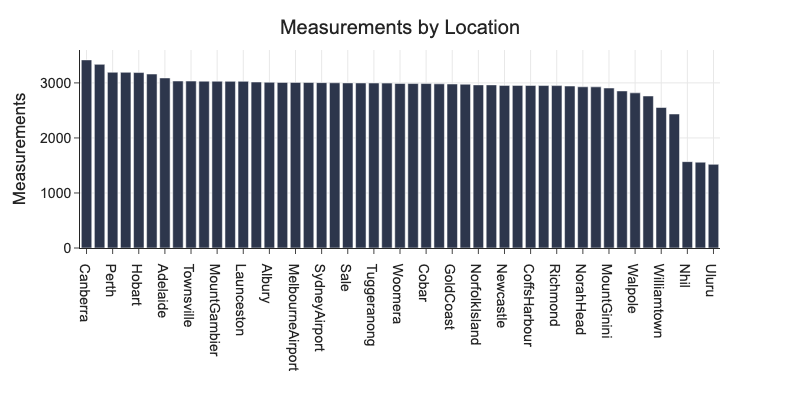

In [15]:
px.bar(d, x=d.index, y='Count', title='Measurements by Location', labels={'Count': 'Measurements', 'Location': ''})

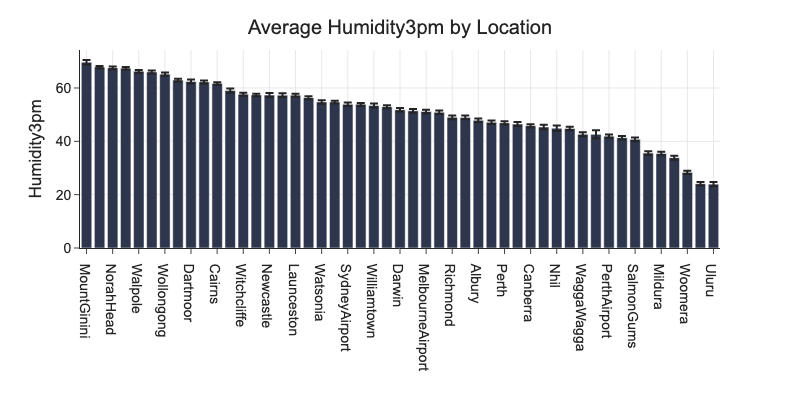

In [16]:
# average humidity by location
d = df.groupby('Location')[['Humidity3pm']].agg(
    cnt=('Humidity3pm', 'count'),
    m=('Humidity3pm', 'mean'),
    se=('Humidity3pm', 'sem')).reset_index()                           

d['ci'] = d.se * st.t.ppf(0.975, d.cnt - 1)
fig = px.bar(d, x='Location', y='m', error_y='ci', title='Average Humidity3pm by Location', labels={'m': 'Humidity3pm', 'Location': ''})
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

<a id="complete"></a>
## Complete, Correct, Create, and Convert

In [17]:
df.isnull().sum().sort_values(ascending=False)

Sunshine         67816
Evaporation      60843
Cloud3pm         57094
Cloud9am         53657
Pressure9am      14014
Pressure3pm      13981
WindDir9am       10013
WindGustDir       9330
WindGustSpeed     9270
WindDir3pm        3778
Humidity3pm       3610
Temp3pm           2726
WindSpeed3pm      2630
Humidity9am       1774
RainToday         1406
Rainfall          1406
WindSpeed9am      1348
Temp9am            904
MinTemp            637
MaxTemp            322
RISK_MM              0
Date                 0
Location             0
RainTomorrow         0
dtype: int64

There are locations completely missing values for *Pressure9am*, *WindGustSpeed*, *Pressure3pm*. Measurement device is probably not present at these locations at all.

Dropping does not make sense here, we would lose whole locations.

Bear in mind that we will have to implement this selective imputation everywhere we prepare data for this model. We will check later if this imputation is worth it.

In [18]:
g = df.groupby('Location').agg(Pressure9amCount=('Pressure9am', 'count'),
                               Pressure3pmCount=('Pressure3pm', 'count'),
                               WindGustSpeedCount=('WindGustSpeed', 'count'))
g[g.Pressure9amCount == 0]

,Pressure9amCount,Pressure3pmCount,WindGustSpeedCount
Location,,,
MountGinini,0,0,2715
Newcastle,0,0,0
Penrith,0,0,2957
SalmonGums,0,0,2909


In [19]:
print(f'If we drop rows with at least one value missing, we get {df.dropna().shape[0]:,} \
out of {df.shape[0]:,} instances.')

If we drop rows with at least one value missing, we get 56,420 out of 142,193 instances.


### Complete

Common strategy is to drop rows with missing values. This could mean dropping substantial amount of data and not being able to predict for many data samples in production. It is always best to check why data are missing and fix them in data collection phase.

Strategies to populate missing values are:

1. Use models that are tolerant to missing values like naive bayes or decision trees.
1. Populate categorical data with mode.
2. Populate numerical data with mean/median, or using group average.
3. Predict missing values using regression from other columns.

We have features with many missing values eg. *Sunshine* and features with some missing values eg. *Temp3pm* probably caused by some malfunction of a measuring unit.

Columns *Evaporation*, *Sunshine*, *Cloud9am*, *Cloud3pm* have many missing values. We fill-in values using iterative regression on few selected features. When many values are missing in some feature, it is worth to add indicator feature informing ML algorithm that particular value was imputed.

In [20]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df['RainToday'] = df['RainToday'].replace({'Yes': 1, 'No': 0})
df['RainTomorrow'] = df['RainTomorrow'].replace({'Yes': 1, 'No': 0})
cols = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Humidity9am', 'Humidity3pm', 'RainToday']
imp = IterativeImputer(initial_strategy='median', add_indicator=True).fit_transform(df[cols].values)

d = pd.DataFrame(imp, columns=cols + [f'{c}_missing' for c in cols])
d.head()[['Evaporation', 'Evaporation_missing', 'Sunshine', 'Sunshine_missing']]

,Evaporation,Evaporation_missing,Sunshine,Sunshine_missing
0,6.251375,1.0,6.960355,1.0
1,8.201791,1.0,10.762692,1.0
2,8.671174,1.0,11.255441,1.0
3,8.275212,1.0,11.644286,1.0
4,4.537052,1.0,4.875672,1.0


In [21]:
d[['Evaporation', 'Evaporation_missing', 'Sunshine', 'Sunshine_missing']].describe()

,Evaporation,Evaporation_missing,Sunshine,Sunshine_missing
count,142193.000000,142193.000000,142193.000000,142193.000000
mean,5.244790,0.427890,7.430390,0.476929
std,3.475205,0.494775,3.374164,0.499469
min,-0.401327,0.000000,0.000000,0.000000
25%,2.979168,0.000000,5.014699,0.000000
50%,4.800000,0.000000,7.717306,0.000000
75%,6.800000,1.000000,10.100000,1.000000
max,145.000000,1.000000,37.475535,1.000000


In [22]:
# replace imputed columns including indicators
# cols_wo_rt = [c for c in cols if 'RainToday' not in c]
# df.drop(cols_wo_rt, axis=1, inplace=True)
# cols_wo_rt = cols_wo_rt + [f'{c}_missing' for c in cols if 'RainToday' not in c]
# df = pd.concat([df, d[cols_wo_rt]], axis=1)

In [23]:
df['RainToday'] = df['RainToday'].fillna(0)

Impute the rest with median for numerical features and mode for categorical features.

In [24]:
from sklearn.impute import SimpleImputer

impute_columns_numerical = ['WindGustSpeed', 'Pressure9am', 'Pressure3pm', 'Temp3pm', 'WindSpeed3pm',
                            'Rainfall', 'WindSpeed9am', 'Temp9am', 'MinTemp', 'MaxTemp', 'Evaporation', 
                            'Sunshine', 'Cloud9am', 'Cloud3pm', 'Humidity9am', 'Humidity3pm']

impute_columns_categorical = ['WindGustDir', 'WindDir9am', 'WindDir3pm']    

for c in impute_columns_numerical:
    df[c] = SimpleImputer(strategy='median').fit_transform(df[c].values.reshape(-1, 1))
    
for c in impute_columns_categorical:
    df[c] = SimpleImputer(strategy='most_frequent').fit_transform(df[c].values.reshape(-1, 1))

Check that we handled everything.

In [25]:
df.isnull().sum().sort_values(ascending=False).head()

Date         0
Location     0
RISK_MM      0
RainToday    0
Temp3pm      0
dtype: int64

### Correct 

We review data for striking errors caused by eg. transformations of data on the source, manual input errors, having numerical feature values as nominal (because `1` is not the same as `"1"`), etc.

In [26]:
# basic overview about distribution of values in numerical columns
cols = ['Cloud9am', 'Humidity9am']
df[cols].describe()

,Cloud9am,Humidity9am
count,142193.000000,142193.000000
mean,4.649568,68.858235
std,2.294357,18.932512
min,0.000000,0.000000
25%,3.000000,57.000000
50%,5.000000,70.000000
75%,6.000000,83.000000
max,9.000000,100.000000


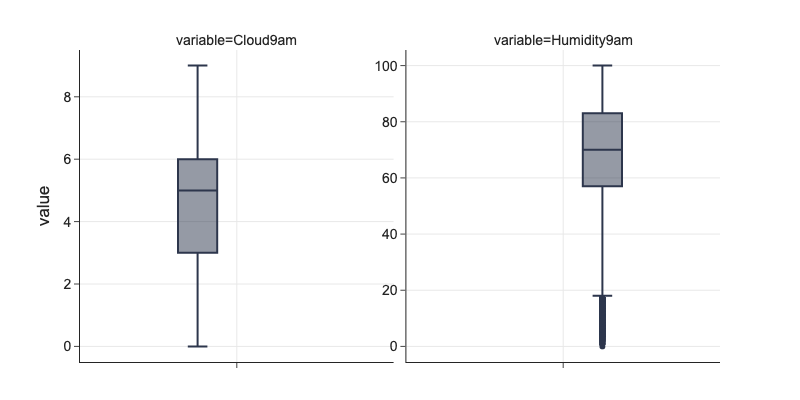

In [27]:
# boxplots
m = pd.melt(df[cols + ['Date', 'Location']], id_vars=['Date', 'Location'], value_vars=cols)
fig = px.box(m, y='value', facet_col='variable', points='outliers', height=400)
fig.update_yaxes(dict(matches=None, showticklabels=True), row=1, col=2)

#### Outliers

Outliers in data could be real eg. some flooding in *Rainfall* or could come from faulty measurement. Outliers skew mean of the feature and some ML algorithms calculating distances like linear models for both classification and regression are sensitive to them.

There are different techniques how to handle outliers:

1. Cap values to stay inside inter quartile range.
1. Bin numerical feature to create categorical values.
1. Apply function transformation that penalizes long-tail outliers eg. taking $log$ of values.

```{sidebar} My sidebar title
![](./imlp1_images/boxplot.png)
```

We cap numerical feature values $v$ to stay be within 

$$q_1 - m * \text{IQR} \le v \le q_3 + m * \text{IQR}$$

Where

1. $q_1$ is 25% quartile
2. $q_3$ is 75% quartile
3. $\text{IQR} = q_3 - q_1$ is inter-quartile range
4. $m$ is constant

IQR is defined as difference between value on 75% quartile ($q_3$) and 25% quartile ($q_1$). We can use different multiples of IQR for different features, common practice is using $m = 1.5$ or $m = 1.8$.

In [28]:
q1 = df[cols].quantile(0.25)
q3 = df[cols].quantile(0.75)
iqr = q3 - q1

df[cols] = df[cols].clip(q1 - 1.5*iqr, q3 + 1.5*iqr, axis=1)
df[cols].describe()

,Cloud9am,Humidity9am
count,142193.000000,142193.000000
mean,4.649568,68.911015
std,2.294357,18.779092
min,0.000000,18.000000
25%,3.000000,57.000000
50%,5.000000,70.000000
75%,6.000000,83.000000
max,9.000000,100.000000


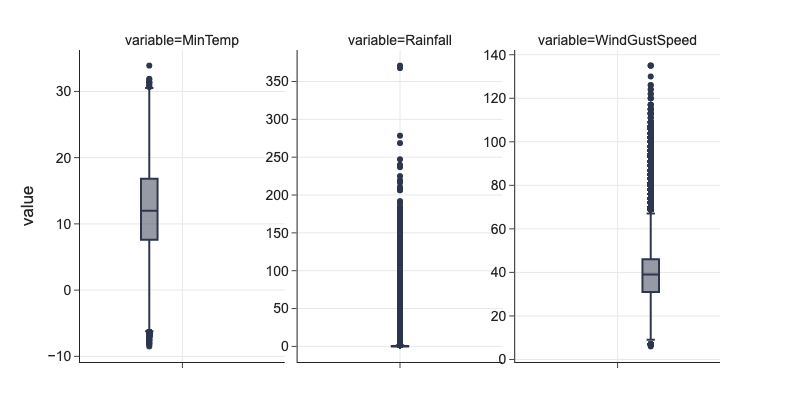

In [29]:
# fixed distributions
cols = ['MinTemp', 'Rainfall', 'WindGustSpeed']
m = pd.melt(df[cols + ['Date', 'Location']], id_vars=['Date', 'Location'])
fig = px.box(m, y='value', facet_col='variable', height=400)
fig.update_yaxes(dict(matches=None, showticklabels=True), row=1, col=2)
fig.update_yaxes(dict(matches=None, showticklabels=True), row=1, col=3)

#### Irregular Cardinality

Some numerical features might be better represented as categorical features because they are coded as ordinal numbers (eg. sex coded as 0 and 1) or because they can have only some specified values.

All our numerical columns seem to have reasonable cardinality and there is probably no candidate for categorical type among numerical features.

In [30]:
df.nunique().sort_values().head(15)

RainTomorrow       2
RainToday          2
Cloud3pm          10
Cloud9am          10
WindDir3pm        16
WindDir9am        16
WindGustDir       16
WindSpeed9am      43
WindSpeed3pm      44
Location          49
WindGustSpeed     67
Humidity9am       83
Humidity3pm      101
Sunshine         145
Evaporation      356
dtype: int64

### Create

We can use our domain knowledge and available features to create new features to determine if they have signal for predicted outcome. We can parse string features, combine features to discover good interactions and amplification effect. We can also crawl data to enhance data points with historical trends, local context, and additional data sources that are available to us (eg. satelite images) and are joinable to existing data.

We check if there was a drop or rise between morning and afternoon pressure.

In [31]:
df['PressureDiff'] = df['Pressure3pm'] - df['Pressure9am']
df['PressureDrop'] = df['PressureDiff'].map(lambda l: 1 if l < 0 else 0)

We include it as an indicator and also as absolute value to check what works better in following exploratory data analysis.

#### Date/Time Features

Date and time data usually provide valuable contextual information but we have to transform the data to make it accessible for ML algorithms. Some ML algorithms can work on time series data and learn trends like periodicity.

Common strategies:

1. Extract year, months, days, week days into separate columns to give the model some information about possible periodicity. This is useful eg. when we process transactional data as weekends are always different from weekdays.
2. Extract time period between events in data. Eg. how long it was from the last event to the data point.
3. Use dates to connect data from additional datasets like holidays, weekends, eg. [Facebook Prophet](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events).

Downside being that when using model in production to predict on one measurement, we have to load preceeing measurements to calculate values for these features. In real-time setting, this requires database lookups.

We extract *Year* and *Month* features here. We also add *DaysSinceRainWeek* to capture how many days passed from the last rain day in rolling week and *RainDaysWeek* to capture how many days with rain there was in rolling week.

In [32]:
# extract year and month
df['DateD'] = pd.to_datetime(df.Date, format='%Y-%m-%d')

df['Year'] = df['DateD'].dt.year.astype('category')
df['Month'] = df['DateD'].dt.month.astype('category')
df['YearMonth'] = df[['Year', 'Month']].apply(lambda r: f'{r[0]}-{r[1]:02d}', axis=1)
df[['Date', 'Year', 'Month', 'YearMonth']].head(5)

,Date,Year,Month,YearMonth
0,2008-12-01,2008,12,2008-12
1,2008-12-02,2008,12,2008-12
2,2008-12-03,2008,12,2008-12
3,2008-12-04,2008,12,2008-12
4,2008-12-05,2008,12,2008-12


In [33]:
def agg_days_since_rain(x):
    x = x[:-1]
    r = np.argmax(np.flip(x)) + 1 if x.any() else 20
    return r

def agg_rain_days(x):
    return np.sum(x[:-1])

def rolling_feature(d, by, on, val, window, name, agg_fce):
    cs = [by, on]
    r = d.sort_values(cs).groupby(by).rolling(window, on=on, min_periods=1)
    
    agg = r.apply(agg_fce, raw=True)
    agg[name] = agg[val] # agg has aggregated values in column val
    agg.drop([val, on], axis=1, inplace=True)
    agg.rename_axis(index=(by, 'Id'), inplace=True)
    agg.reset_index(inplace=True)
    return agg

#### Contextual Features

We can look beyond single row of data to calculate some contextual features. Keep in mind that when in production mode, we would need to load context for every row we want to predict for from somewhere. In current setting, we can cheaply evaluate if adding such features help performance of the model.

We use last 7 days of data per *Location* to calculate features

1. *RainDaysWeek* capturing how many times it rained in the last week (excluding given day)
1. *DaysSinceRainWeek* capturing how long it is since the last rainy day in the last week.

In [34]:
# rolling_feature is custom rolling window function that takes different aggregation functions
dsrw = rolling_feature(df[['DateD', 'Location', 'RainToday']], 'Location', 'DateD', 'RainToday', 8, 'DaysSinceRainWeek', agg_days_since_rain)
rdw = rolling_feature(df[['DateD', 'Location', 'RainToday']], 'Location', 'DateD', 'RainToday', 8, 'RainDaysWeek', agg_rain_days)

# prepare original dataset to have the same index as rv
d = df.copy()
d.set_index(['Location'], append=True, inplace=True)
d.rename_axis(('Id', 'Location'), inplace=True)
d.reset_index(inplace=True)

# merge new features and drop technical columns
d = d.merge(dsrw, on=['Id', 'Location'])
d = d.merge(rdw, on=['Id', 'Location'])

d['NoRainWeek'] = d['DaysSinceRainWeek'].map(lambda l: 1 if l == 20 else 0)
d['DaysSinceRainWeek'] = d['DaysSinceRainWeek'].replace({20: 0})

d[(d.Location == 'Melbourne')][['Date', 'Location', 'RainToday', 'DaysSinceRainWeek', 'NoRainWeek', 'RainDaysWeek']].head(10)

,Date,Location,RainToday,DaysSinceRainWeek,NoRainWeek,RainDaysWeek
65745,2008-07-01,Melbourne,1.0,0.0,1,0.0
65746,2008-07-02,Melbourne,0.0,1.0,0,1.0
65747,2008-07-03,Melbourne,1.0,2.0,0,1.0
65748,2008-07-04,Melbourne,0.0,1.0,0,2.0
65749,2008-07-05,Melbourne,0.0,2.0,0,2.0
65750,2008-07-06,Melbourne,0.0,3.0,0,2.0
65751,2008-07-07,Melbourne,0.0,4.0,0,2.0
65752,2008-07-08,Melbourne,1.0,5.0,0,2.0
65753,2008-07-09,Melbourne,1.0,1.0,0,2.0
65754,2008-07-10,Melbourne,1.0,1.0,0,3.0


In [35]:
df = d

### Convert

Some ML algorithms cannot handle non-numeric values in features like linear models or neural nets. We have to encode categorical features using either dummy values or better using one-hot encoding which helps with colinear features. It is good practice to encode categorical values also for ML algorithms that can handle them like decision trees and forrests of trees to be able to test, use, and combine multiple algorithms.

#### Categorical Features to Numerical

In [36]:
df[['WindGustDir', 'Location', 'Year']].head(5)

,WindGustDir,Location,Year
0,W,Albury,2008
1,WNW,Albury,2008
2,WSW,Albury,2008
3,NE,Albury,2008
4,W,Albury,2008


We need to convert categorical values into numerical because many ML algorithms can handle only float numbers on input. We cannot simply assign natural numbers to categories, because numbers encode ordering implicitly and this is then picked by models. For example if we encode *North* as 0 and *South* as 1, South is greater than North. 

#### One-hot Encoding

*One-hot encoding* encodes categorical or ordinal features as nominal using "flag columns" or "dummy values" of zeros and ones. 

When you have $N$ distinct values in some feature, we need $N-1$ flag columns to represent it. The $N$th value is represented with all flag columns of zeros. This helps with ML algorithms that are sensitive to colinearity eg. linear and logistic regression without regularization and neural nets.

In [37]:
from sklearn.preprocessing import OneHotEncoder

v = df['WindGustDir'].values.reshape(-1, 1)
e = OneHotEncoder(drop='first', sparse=False).fit(v)
p = pd.DataFrame(e.transform(v), columns=e.categories_[0][1:])
d = pd.concat([df['WindGustDir'], p], axis=1)
d.head(5)

,WindGustDir,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,WNW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,WSW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,NE,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


East *WindGustDir* is encoded using all zeros in remaining flag columns.

In [38]:
d[d.WindGustDir == 'E'].head(3)

,WindGustDir,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
76,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id="eda"></a>
## Exploratory Data Analysis

We explore values in available features to learn their distributions, evaluate their impact on target feature, learn how they interact and study them in detail. The output are learnings, detailed questions to data providers, knowing what transformations we have to apply to data before passing them to ML algorithm.

### Categorical Feature

We could check proportion of positive level of target feature in different levels of categorical feature.

Plotting of confidence intervals gives us some idea about the absolute number and variance of samples in every level of categorical feature.

In [39]:
categorical_columns = list(df.select_dtypes(['object']).columns) + ['PressureDrop', 'RainToday']
categorical_columns

['Location',
 'Date',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'YearMonth',
 'PressureDrop',
 'RainToday']

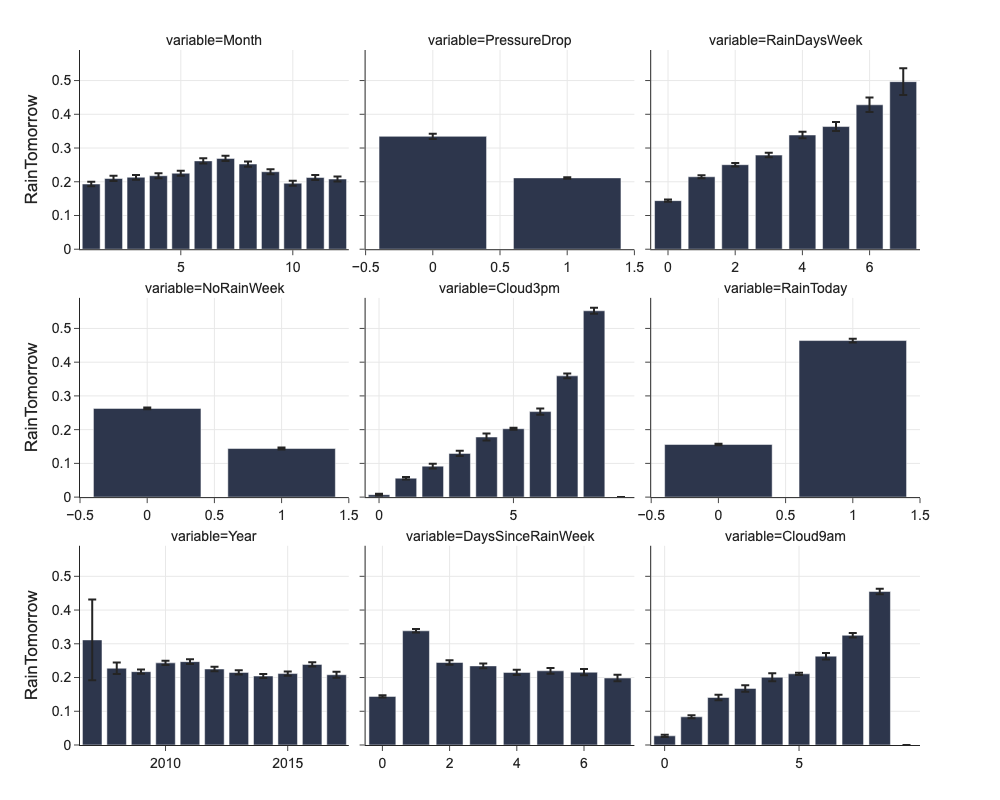

In [45]:
png_renderer.height = 800
png_renderer.width = 1000
d = mlp.eda_categorical(df, 'RainTomorrow', max_categorical_values=12)
fig = px.bar(d, x='value', y='mean', error_y='ci', facet_col='variable',
       facet_col_wrap=3,
       labels={'value': '', 'mean': 'RainTomorrow'})
fig.update_xaxes(dict(matches=None, showticklabels=True))

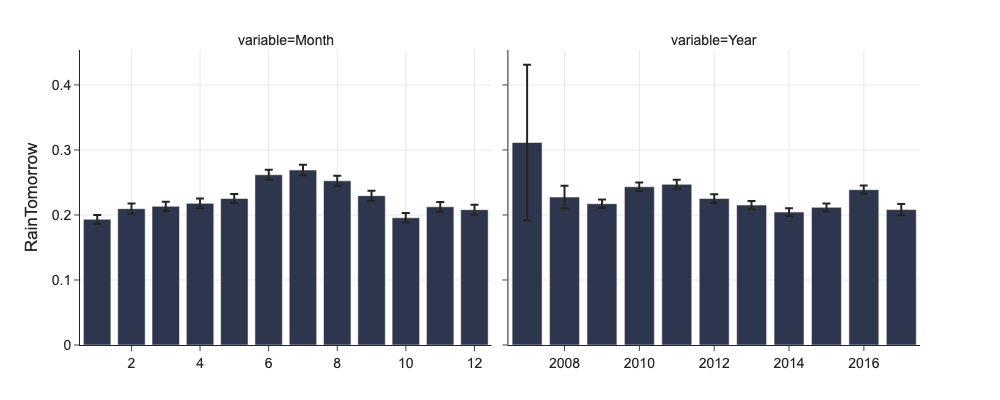

In [46]:
# annual and monthly rainy days
png_renderer.height = 400
fig = px.bar(d[d.variable.isin(['Year', 'Month'])], x='value', y='mean', error_y='ci', facet_col='variable',
       facet_col_wrap=2,
       labels={'value': '', 'mean': 'RainTomorrow'})
fig.update_xaxes(dict(matches=None, showticklabels=True))

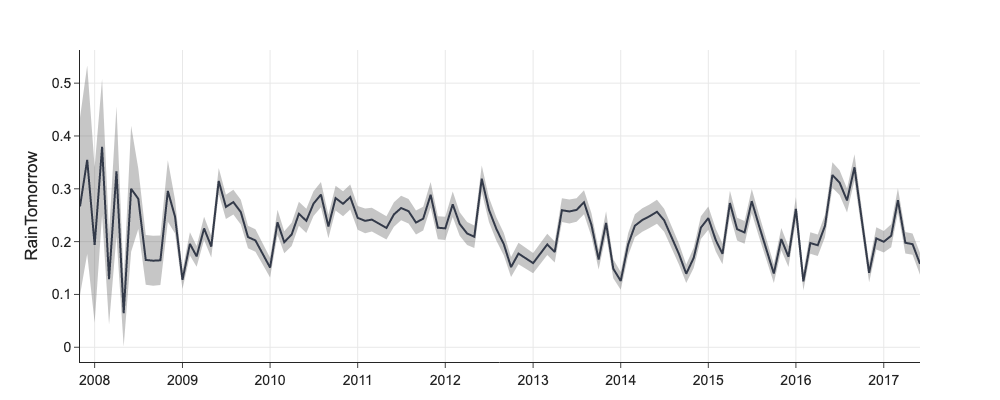

In [47]:
# annual and monthly rainy days
d = eda_categorical(df[['RainTomorrow', 'YearMonth']], 'RainTomorrow', max_categorical_values=0)

fig = go.Figure([
    go.Scatter(name='RainTomorrow', x=d['value'], y=d['mean'], mode='lines', showlegend=False),
    go.Scatter(x=d['value'], y=d['mean']+d['ci'], mode='lines', line=dict(width=0), showlegend=False),
    go.Scatter(x=d['value'], y=d['mean']-d['ci'], mode='lines', line=dict(width=0), showlegend=False,
               fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty')
])
fig.update_layout(title='', yaxis_title='RainTomorrow')

### Numerical Features

We check univariate distribution of numerical feature against target variable using histograms or eg. [kernel density](https://en.wikipedia.org/wiki/Kernel_density_estimation) plots. If distributions are distinct, we have a good predictive feature.

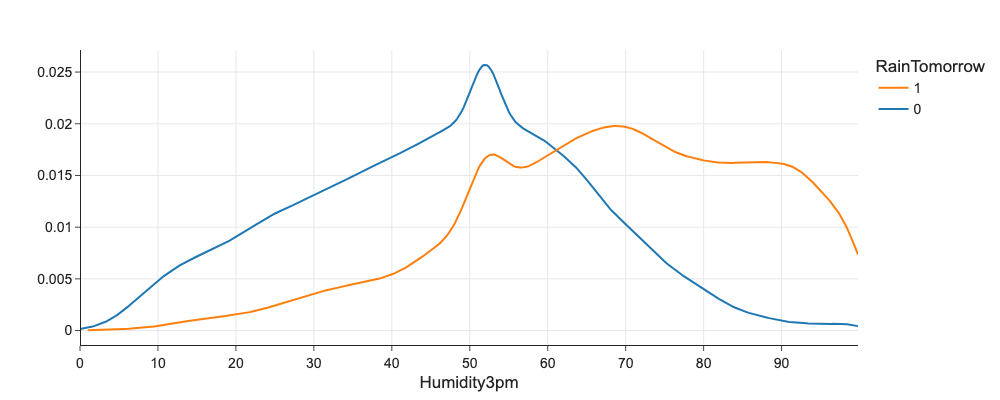

In [48]:
# does Humidity3pm correlates with RainTomorrow?
import plotly.figure_factory as ff
fig = ff.create_distplot(
    [df[df.RainTomorrow == 0]['Humidity3pm'], df[df.RainTomorrow == 1]['Humidity3pm']],
    ['0', '1'],
    bin_size=1,
    show_hist=False,
    show_rug=False,
    show_curve=True,
)
fig.update_layout(xaxis_title='Humidity3pm', legend_title='RainTomorrow')

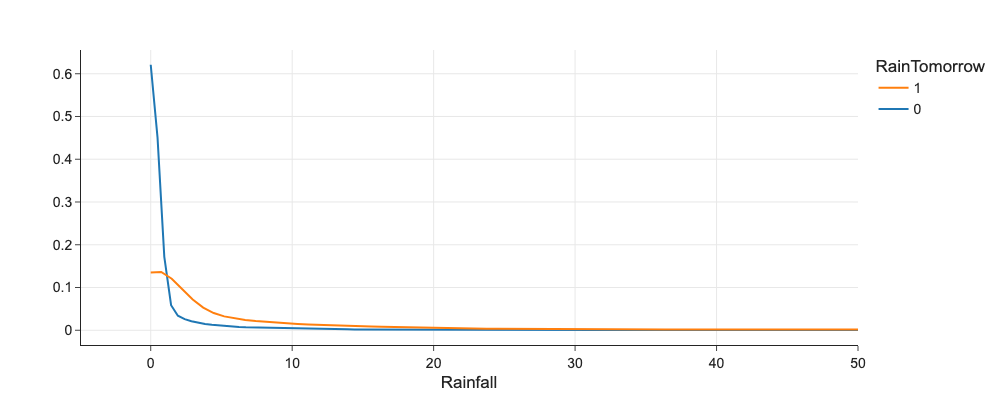

In [51]:
# does Humidity3pm correlates with RainTomorrow?
import plotly.figure_factory as ff
fig = ff.create_distplot(
    [df[df.RainTomorrow == 0]['Rainfall'], df[df.RainTomorrow == 1]['Rainfall']],
    ['0', '1'],
    bin_size=1,
    show_hist=False,
    show_rug=False,
    show_curve=True,
)
fig.update_layout(xaxis_title='Rainfall', legend_title='RainTomorrow', xaxis_range=[-5,50])

### Categorical vs. Categorical

We can use grouped bar charts to check how are combinations of two categorical features represented in target feature.

In [61]:
# do RainToday and DaysSinceRainWeek or RainDaysWeek influence RainTomorrow?
d = eda_categorical(df, 'RainTomorrow', ['RainToday', 'DaysSinceRainWeek'])
fig = px.bar(d, x='RainToday', y='mean', color='DaysSinceRainWeek', error_y='ci', barmode='stack')
fig.update_coloraxes(type='category')

ValueError: Invalid property specified for object of type plotly.graph_objs.layout.Coloraxis: 'type'

Did you mean "cmax"?

    Valid properties:
        autocolorscale
            Determines whether the colorscale is a default palette
            (`autocolorscale: true`) or the palette determined by
            `colorscale`. In case `colorscale` is unspecified or
            `autocolorscale` is true, the default  palette will be
            chosen according to whether numbers in the `color`
            array are all positive, all negative or mixed.
        cauto
            Determines whether or not the color domain is computed
            with respect to the input data (here corresponding
            trace color array(s)) or the bounds set in `cmin` and
            `cmax`  Defaults to `false` when `cmin` and `cmax` are
            set by the user.
        cmax
            Sets the upper bound of the color domain. Value should
            have the same units as corresponding trace color
            array(s) and if set, `cmin` must be set as well.
        cmid
            Sets the mid-point of the color domain by scaling
            `cmin` and/or `cmax` to be equidistant to this point.
            Value should have the same units as corresponding trace
            color array(s). Has no effect when `cauto` is `false`.
        cmin
            Sets the lower bound of the color domain. Value should
            have the same units as corresponding trace color
            array(s) and if set, `cmax` must be set as well.
        colorbar
            :class:`plotly.graph_objects.layout.coloraxis.ColorBar`
            instance or dict with compatible properties
        colorscale
            Sets the colorscale. The colorscale must be an array
            containing arrays mapping a normalized value to an rgb,
            rgba, hex, hsl, hsv, or named color string. At minimum,
            a mapping for the lowest (0) and highest (1) values are
            required. For example, `[[0, 'rgb(0,0,255)'], [1,
            'rgb(255,0,0)']]`. To control the bounds of the
            colorscale in color space, use`cmin` and `cmax`.
            Alternatively, `colorscale` may be a palette name
            string of the following list: Blackbody,Bluered,Blues,C
            ividis,Earth,Electric,Greens,Greys,Hot,Jet,Picnic,Portl
            and,Rainbow,RdBu,Reds,Viridis,YlGnBu,YlOrRd.
        reversescale
            Reverses the color mapping if true. If true, `cmin`
            will correspond to the last color in the array and
            `cmax` will correspond to the first color.
        showscale
            Determines whether or not a colorbar is displayed for
            this trace.
        
Did you mean "cmax"?

Bad property path:
type
^^^^

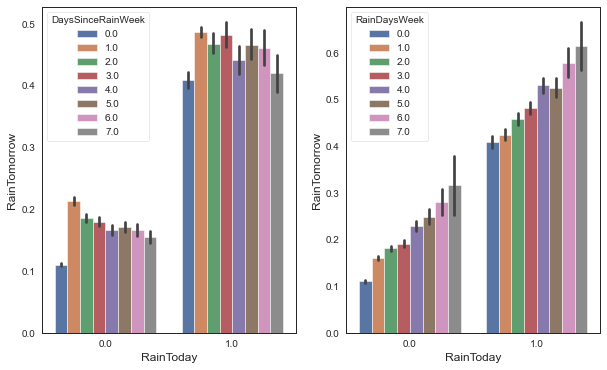

In [47]:
# do RainToday and DaysSinceRainWeek or RainDaysWeek influence RainTomorrow?
sns.set_palette('deep')
plt.figure(figsize=[10,6])
plt.subplot(121)
sns.barplot(x='RainToday', hue='DaysSinceRainWeek', y='RainTomorrow', data=df);
plt.subplot(122)
sns.barplot(x='RainToday', y='RainTomorrow', hue='RainDaysWeek', data=df);
sns.set_palette(def_palette)

### Categorical vs. Numerical

We can use bar charts or violin plots groupped by target feature to check distribution of some numerical feature against values of categorical feature.

1. Bars give us point estimate of the mean value.
2. Box plots give us spread, quartiles, and outliers.
3. Violin plots give us pdf.

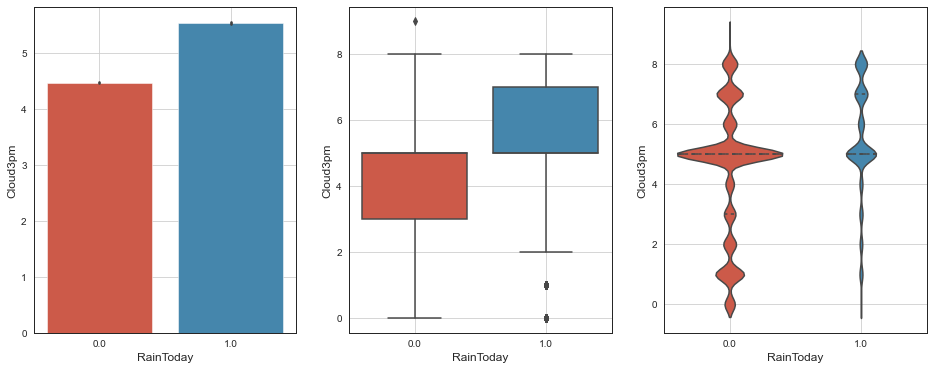

In [48]:
# more details about numerical feature distribution

plt.figure(figsize=[16,6])
plt.subplot(131)
sns.barplot(x='RainToday', y='Cloud3pm', data=df);
plt.grid()
plt.subplot(132)
sns.boxplot(x='RainToday', y='Cloud3pm', data=df);
plt.grid()
plt.subplot(133)
sns.violinplot(x='RainToday', y='Cloud3pm', data=df, split=True, inner='quartile', scale='count');
plt.grid();

To check impact of category and numerical feature to target feature, we can use color by target feature.

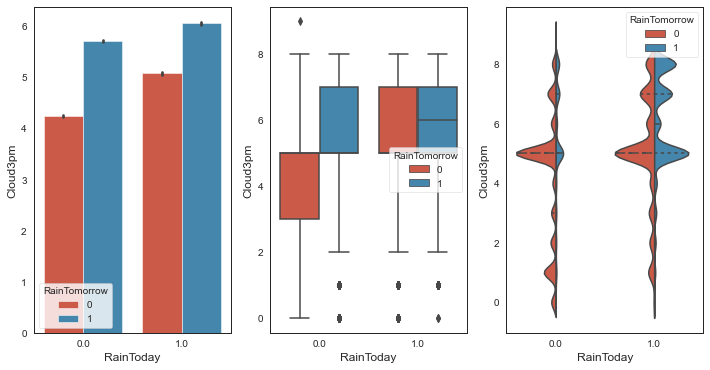

In [49]:
# going deeper
plt.figure(figsize=[12,6])
plt.subplot(131)
sns.barplot(x='RainToday', y='Cloud3pm', hue='RainTomorrow', data=df);
plt.subplot(132)
sns.boxplot(x='RainToday', y='Cloud3pm', hue='RainTomorrow', data=df);
plt.subplot(133)
sns.violinplot(x='RainToday', y='Cloud3pm', hue='RainTomorrow', data=df, split=True, inner='quartile', scale='count');

### Facets

We can facet plots by values of some categorical features to investigate interactions of upto 4 features agaist target feature. We generally put target variable on *y* axis, and use *x*, *columns*, *rows*, and *hue* for upto 4 explanatory features.

<Figure size 1440x504 with 0 Axes>

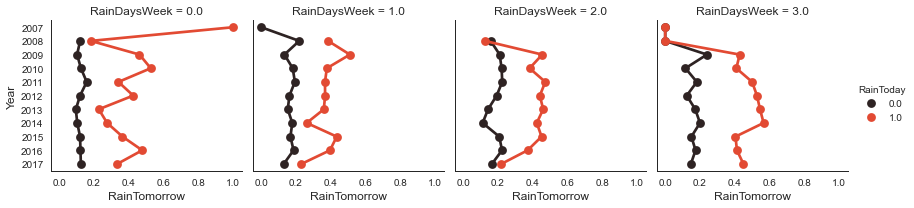

In [50]:
# facets
plt.figure(figsize=[20,7]);
f = sns.FacetGrid(df[df.RainDaysWeek.isin([0, 1, 2, 3])].sample(10000), col='RainDaysWeek');
f.map(sns.pointplot, 'RainTomorrow', 'Year', 'RainToday', ci=0.90, grid=True);
f.add_legend(title='RainToday');

### Interactions of Pairs of Features Using Pair Plots or Scatter Plots

We can use Seaborn *pairplot* to have analyze interactions and distributions of many features at once. These plots need time to plot and are best used printed :)

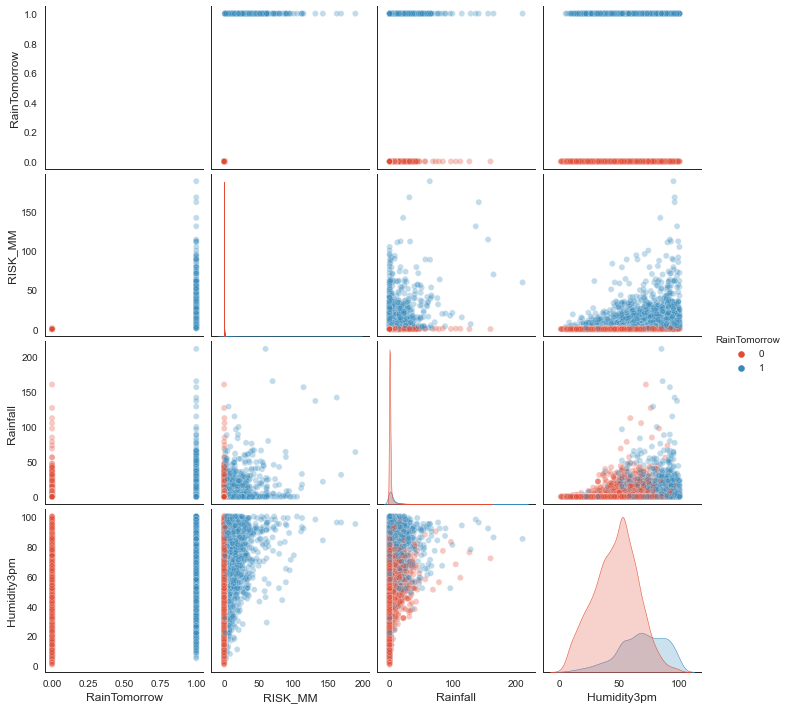

In [51]:
# beware this takes long minutes to calculate and display
vars = ['RainTomorrow', 'RISK_MM', 'Rainfall', 'Humidity3pm']
sns.pairplot(df[vars].sample(10000), vars=vars, hue='RainTomorrow', plot_kws={'alpha': 0.3});

### [Finantial Times Visual Vocabulary](https://github.com/ft-interactive/chart-doctor/tree/master/visual-vocabulary)

<img src="./imlp1_images/ft_poster.png" width="800" />

### Covariance

It is not sometimes straightforward to inspect relationshipe between features visually when there are hundreds or thousands of features. *Covariance* measures how similarly values of two features *A* and *B* behave in relation to their respective means.

$$\text{cov}(a, b) = \frac{1}{n - 1}\sum_{i=1}^{n}((a_i - \bar{a}) \times (b_i - \bar{b}))$$

Positive values of covariance signal that positive relationship, negative values signal negative relationship and values around $0$ signal no relationship. Covariance values are in units of features, it makes no sense to compare pairs of features using it.

### Correlation

Normalized covariance is called *correlation* and it is in interval $[-1,1]$. 

$$\text{corr}(a, b) = \frac{\text{cov}(a, b)}{\sigma_a \times \sigma_b}$$

Correlation captures only linear relationshipes between features, there could be more complex relationships like quadratical that we do not discover using correlation. When we calculate correlations for all features, we get correlation matrix good for visual inspection.

In [52]:
# correlations
corr = df.corr()
top_corrs = corr['RainTomorrow'].abs().sort_values(ascending=False)[:10].index
corr.ix[top_corrs][top_corrs]

fix, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr.ix[top_corrs][top_corrs], cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax,
            square=True, annot=True, annot_kws={'size': 11}, linewidth=.5)
ax.set_title('Correlations')
ax.set_ylim((10, 0));
plt.yticks(rotation=0);

AttributeError: 'DataFrame' object has no attribute 'ix'

Correlation is not causation: 

1. Swallows cause hot weather, spinning windmills cause wind, playing basketball causes people to be tall.
2. Confounding feature (hidden 3rd factor) eg. young children sleeping with night-light turned on developing short-sightedness

Causation can be only proved by random experiment.

Features with strong correlation with the target are suspicious and worth investigation. It could be a hint of hidden leaks like time traveling in features etc.

<a id="prepare"></a>
## Data Preparation

### Normalization

Features usually vary a lot in their ranges. This is a problem to any ML algorithm using distances like k-nearest neighbors, to PCA which works with variance which is high for high-magnitude features, or to deep learning where it slows down gradient descend or even disables its convergence completely. For example if feature $x \in [0, 5]$ and feature $z \in [0, 1000]$ then increase by $1$ in $x$ and $z$ means something different and we cannot compare it.

Normalize into $[0, 1]$ by

$$ x_i = \frac{x_i - \min(x)}{\max(x) - min(x)}$$


Standardize by

$$ x_i = \frac{x_i - \bar{x}}{\sigma_x}$$

In [ ]:
# examples of normalization

from sklearn.preprocessing import StandardScaler, normalize

d = df['Pressure9am'].dropna()
ds = StandardScaler().fit_transform(d.values.reshape(-1, 1))
dn = (d - d.min()) / (d.max() - d.min())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6));
sns.distplot(d, ax=ax[0], label='Original');
sns.distplot(dn, ax=ax[1], label='Normalize');
sns.distplot(ds[:,0], ax=ax[2], label='Standard Scaler');
for i in range(len(ax)):
    ax[i].legend();
    ax[i].grid()
    ax[i].set_xlabel('Pressure9am');

### Binning

Binning converts continous feature into categorical one for better interpretation of the model, better generalization, and preventing overfitting. Eg. latitude have impact on housing price, but not linear, we could bin latitude to make it categorical.

<img width="800" src="./imlp1_images/latitude_bin.png" />

[Machine Learning Crash Course, Google](https://developers.google.com/machine-learning/data-prep/transform/bucketing)

We can:

1. Create **equally-wide** bins - does not work well for uni-modal distributions because few bins will have many samples and many bins will cover long tail with few samples each.
2. Create **equal-frequency** bins - more appropriate for uni-modal but is less explainable.

Binning handles outliers automatically.

For categorical data, it might be benefitial to squash low-frequent values under 'Other', you do not want necesirily to end up with sparse feature matrices.

### Fixing Skewness

Taking log of values makes exponential or "long-tail" distributions more normal. 

1. Logarithm makes comparisons of values of many orders of magnitudes possible eg. change from 1 to 10 is the same as change from 10 000 to 100 000 (consider eg. value of money).
2. In many datasets, magnitude order of the data changes within the range of the data.
3. It handles outliers.

#### Box-cox

Box-cox (power) transformation is generalization of taking $log$ of features. Box-cox transform first fits $\lambda$ using maximum log-likelihood method to feature values.

$$
 y_i^{(\lambda)} = 
  \begin{cases} 
   \frac{y_i^\lambda - 1}{\lambda} & \text{if } \lambda \ne 0 \\
   \ln(y_i) & \text{if } \lambda = 0
  \end{cases}
$$

In [ ]:
# example of long-tailed distribution
import scipy as sc

d = df['WindSpeed9am'].dropna()
l, lmbda = sc.stats.boxcox(d+1)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12));
sns.distplot(d, ax=ax[0][0], label='WindSpeed9am');
sns.distplot(np.log(d+1), ax=ax[0][1], label='Log');
sns.distplot(np.sqrt(d), ax=ax[1][0], label='Sqrt');
sns.distplot(sc.stats.boxcox(d+1, lmbda=lmbda), label=f'Box-Cox ({lmbda:.3})', ax=ax[1][1]);
for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i][j].legend(); 
        ax[i][j].set_xlabel('');
        ax[i][j].grid();

### Dimensionality Reduction

High-dimensional datasets can be very difficult to visualize. While data in two or three dimensions can be plotted to show the inherent structure of the data, equivalent high-dimensional plots are much less intuitive. To aid visualization of the structure of a dataset, the dimension must be reduced in some way.

The simplest way to accomplish this dimensionality reduction is by taking a random projection of the data. Though this allows some degree of visualization of the data structure, the randomness of the choice leaves much to be desired. In a random projection, it is likely that the more interesting structure within the data will be lost. [Link](https://scikit-learn.org/stable/modules/manifold.html)

<img src="./imlp1_images/manifold.png" width="800" />

[Scikit-learn Manifold Learning](https://scikit-learn.org/stable/modules/manifold.html)

Linear decomposition frameworks like *principal component analysis* (PCA) and non-linear *manifold learning* (t-SNE) can make these projections possible and informative. Manifold learning is not that intuitive compared to linear decomposition and needs good parameter tuning (see eg. nice visualization building some intuition in [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)).

<img width="800" src="./imlp1_images/tsne.png"/>

[Distill.pub, How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne)

In [ ]:
# beware, this takes about 30 minutes to compute
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = []
features += [('Location', OneHotEncoder(drop='first', sparse=False), ['Location'])]
features += [('YearMonth', OneHotEncoder(drop='first', sparse=False, categories='auto'), ['YearMonth'])]
features += [('Humidity3pm', SimpleImputer(strategy='mean'), ['Humidity3pm'])]

pipeline_pca = Pipeline([('ct', ColumnTransformer(features)),
                         ('sca', StandardScaler()),
                         ('pca', PCA(n_components=2))
                        ])

pipeline_tsne = Pipeline([('ct', ColumnTransformer(features)),
                          ('sca', StandardScaler()),
                          ('tsne', TSNE(n_components=2, perplexity=50)),
                         ])

o_pca = np.hstack((pipeline_pca.fit_transform(df), df['RainTomorrow'].values.reshape(-1, 1)))
d_pca = pd.DataFrame(o_pca, columns=['Component 1', 'Component 2', 'RainTomorrow'])

o_tsne = np.hstack((pipeline_tsne.fit_transform(df), df['RainTomorrow'].values.reshape(-1, 1)))
d_tsne = pd.DataFrame(o_tsne, columns=['Component 1', 'Component 2', 'RainTomorrow'])

In [ ]:
# plotting PCA and t-SNE
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6));
axx = sns.scatterplot(x='Component 1', y='Component 2', hue='RainTomorrow', data=d_pca, alpha=0.5, ax=ax[0]);
axx.set_title('PCA');
axx.grid();

axx = sns.scatterplot(x='Component 1', y='Component 2', hue='RainTomorrow', data=d_tsne, alpha=0.5, ax=ax[1]);
axx.set_title('t-SNE');
axx.grid();

### Handling Class Imbalance

In a case where we have 2% to 98% imbalanced dataset, always predicting majority class gives us model with 98% accuracy.

Imbalanced datasets are common. [Accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox) tells us that accuracy defined as is not a good metric. Accuracy is defined as number of correctly classified instances / all instances.

Strategies:

1. Use **penalized models** - model pays more when missclassifying minority class.
1. **Under-sample** majority class if you have many data.
1. **Over-sample** minority class if you do not have enough data.
1. Generate **synthetic samples** using eg. [imblearn](https://imbalanced-learn.readthedocs.io/en/stable/index.html)’s SMOTE or Synthetic Minority Oversampling Technique.
1. Use precission, recall, f1-score to evaluate model, they do not have accuracy paradox.
1. Change model, eg. random forests are not that sensitive to imbalanced datasets.

When doing over-sampling, always sample after splitting the dataset into training and testing (, validation) datasets.

Over-sampling Using SMOTE and ADASYN Techniques

<img width="800" src="./imlp1_images/decision_random.png" />

<img width="800" src="./imlp1_images/decision_smote.png" />

<img width="700" src="./imlp1_images/decision_adasyn.png" />

Decision boundaries.

<img width="1000" src="./imlp1_images/over_sampling_models.png" />

[Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning](https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#more-advanced-over-sampling-using-adasyn-and-smote).

Our dataset is slightly imbalanced, we will see how different algorithms handle this in the next lesson.

In [ ]:
df['RainTomorrow'].value_counts()

<a id="model"></a>
## Model

Let's try to combine all we learned into one dataset and let's use some simple model on it.

We first encode categorical feature using OHE.

In [ ]:
numeric_columns = list(df.select_dtypes(['float64']).columns) + list(df.select_dtypes(['int64']).columns)
numeric_columns.remove('RainTomorrow')
numeric_columns.remove('Id')

ohe = OneHotEncoder(drop='first', sparse=False).fit_transform(df[['WindDir9am', 'WindDir3pm', 'WindGustDir', 'Location', 'YearMonth']])
train = np.hstack([ohe, df[numeric_columns + ['RainTomorrow']]])

We keep 30% of samples out of sight of the model to have a good way to evaluate model performance.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size=0.3)
x_train = train[:, :-1]
y_train = train[:, -1]
x_test = test[:, :-1]
y_test = test[:, -1]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(x_train, y_train);

from sklearn.metrics import classification_report
print('Classifition report on testing dataset')
print(classification_report(y_test, model.predict(x_test)))

## It looks too good to be true!

Do you know what the problem could be?

## Resources

1. John D. Kelleher et al., [Fundamentals of Machine Learning for Predicitve Data Analytics](https://www.amazon.com/Fundamentals-Machine-Learning-Predictive-Analytics/dp/0262029448/ref=sr_1_1?keywords=machine+learning+for+predictive+data+analytics&qid=1569507170&sr=8-1)
2. Sebastian Raschka, [Python Machine Learning](https://www.amazon.com/Python-Machine-Learning-Sebastian-Raschka-ebook/dp/B00YSILNL0)
2. [A Data Science Framework to chieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/notebook)
1. [Google - Machine Learning Crash Course](https://developers.google.com/machine-learning/data-prep)